# Design of Experiment: персонализированная карусель курсов


## Цель эксперимента

Цель данного этапа проекта — спроектировать A/B-тест для оценки влияния персонализированной карусели курсов «Вам понравится» на поведение пользователей образовательной платформы.

В рамках ноутбука выполняется:
- формулировка продуктовой гипотезы;
- выбор ключевых, вспомогательных и guardrail-метрик;
- определение единицы рандомизации и дизайна эксперимента;
- оценка минимального детектируемого эффекта (MDE) и требований к размеру выборки.

Фактические результаты A/B-теста в рамках данного проекта не анализируются.

## Гипотеза

Внедрение персонализированной карусели курсов «Вам понравится» приводит к увеличению конверсии в запись на курс после клика по карточке курса (**CR_enroll**) по сравнению со стандартной (неперсонализированной) каруселью.

Дополнительно предполагается, что рост эффективности персонализации на этапе принятия решения может в дальнейшем положительно повлиять на поведенческие и финансовые показатели, такие как **CTR**, **AOV** и **ARPU**, однако данные метрики рассматриваются как вспомогательные и не используются в качестве основного критерия успешности эксперимента.


## Метрики эксперимента

Для оценки эффекта персонализированной карусели курсов используются ключевые, вспомогательные и guardrail-метрики. Все метрики рассчитываются на уровне пользователя (user-level) и анализируются только для пользователей, которые имели хотя бы один просмотр карусели рекомендаций (`view_carousel`).

### Ключевая метрика

**CR_enroll** — конверсия в запись на курс после клика по карточке курса.  
Метрика рассчитывается как доля пользователей, которые записались на курс, среди пользователей, совершивших клик по карточке курса в карусели.

CR_enroll выбрана в качестве основной метрики, так как она напрямую отражает влияние персонализации на этап принятия решения и менее подвержена шуму, связанному с альтернативными пользовательскими путями.

### Вспомогательные (secondary) метрики

**CTR** — доля пользователей, совершивших клик по карточке курса после просмотра карусели.  
Метрика используется для оценки влияния персонализации на вовлечённость пользователей и может служить ранним индикатором эффекта.

**AOV** — средний чек оплаты курса среди пользователей, совершивших покупку.  
Метрика отражает возможное влияние персонализации на структуру покупок, но в рамках текущих данных используется только на уровне гипотезы.

**ARPU** — выручка, приходящаяся на одного пользователя.  
Метрика используется для оценки потенциального влияния персонализации на выручку в долгосрочной перспективе.

### Охраняющие (guardrail) метрики

Охраняющие метрики используются для контроля того, что возможный рост ключевой метрики не достигается за счёт ухудшения пользовательского опыта или деградации воронки.

В рамках эксперимента контролируются:
- доля пользователей, не совершивших ни одного клика после просмотра карусели;
- сквозная конверсия от просмотра карусели до записи на курс (view → enroll);
- стабильность распределения просмотров и кликов по карусели между контрольной и тестовой группами.

Эксперимент считается корректным только при отсутствии негативного эффекта по охраняющим метрикам.


## Единица рандомизации и уровень агрегации

Единицей эксперимента является **пользователь (client_id)**.

Все метрики эксперимента рассчитываются на уровне пользователя (user-level), так как:
- рандомизация осуществляется по пользователям,
- пользователь получает либо персонализированную, либо стандартную карусель,
- повторные события одного пользователя не являются независимыми наблюдениями.

Агрегация на уровне user-day может использоваться исключительно для описательных целей
и визуализации динамики, но не для статистических выводов.


## Дизайн эксперимента

- Тип эксперимента: A/B-тест
- Группы:
  - A — стандартная (неперсонализированная) карусель
  - B — персонализированная карусель «Вам понравится»
- Разделение пользователей: 50% / 50%
- Доля трафика в эксперименте: не более 20% от общего
- Продолжительность теста: 7 дней
- Уровень значимости: α = 0.05
- Мощность теста: 80%


### Допущения

При проектировании A/B-теста приняты следующие допущения:

- пользователи случайным образом и равномерно распределяются между контрольной и тестовой группами;
- поведение пользователей в среднем стабильно в течение эксперимента;
- пользователи не влияют на поведение друг друга;
- логирование ключевых событий (view, click, enroll, pay) является корректным и сопоставимым между группами;
- персонализация влияет на выбор курсов, но не изменяет платёжную механику и цены.

Нарушение любого из указанных допущений может привести к искажению оценки эффекта эксперимента.

## Анализ исторических данных

Для оценки базовых значений метрик были использованы исторические данные до запуска эксперимента.

Ключевые ограничения данных:
- крайне низкая пользовательская активность,
- отсутствие покупок среди пользователей, просмотревших карусель,
- невозможность эмпирической оценки дисперсий для CR_enroll, AOV и ARPU.

В связи с этим расчёты ниже выполняются на основе допущений и/или прокси-метрик.


Baseline-оценки и ограничения данных основаны на результатах exploratory analysis (см. ноутбук `1_exploratory_analysis.ipynb`).

baseline используется исключительно для поведенческих метрик,
для revenue-метрик baseline не может быть оценён на этих данных.

## Минимальный детектируемый эффект (MDE)

Минимальный детектируемый эффект (MDE) — это наименьшее изменение ключевой метрики, которое A/B-тест способен обнаружить с заданной вероятностью при фиксированном уровне значимости. Иными словами, MDE отвечает на вопрос: *насколько сильным должен быть эффект, чтобы эксперимент смог его зафиксировать при текущем объёме данных*.

### Подход к оценке MDE

В рамках данного проекта расчёт MDE выполняется на этапе проектирования эксперимента и используется для оценки реалистичности запуска A/B-теста при заданных ограничениях по трафику и длительности.

Из-за отсутствия наблюдаемых конверсий в исторических данных карусели невозможно напрямую оценить базовый уровень CR_enroll и его вариативность. В связи с этим для демонстрации подхода используется гипотетическое baseline-значение CR_enroll, основанное на продуктовых бенчмарках EdTech.

Данное допущение применяется исключительно в иллюстративных целях и не интерпретируется как ожидаемый эффект или прогноз результатов эксперимента.

### Зависимость MDE от размера выборки

Для оценки чувствительности эксперимента анализируется зависимость MDE от размера выборки при фиксированных параметрах теста (уровень значимости 5%, мощность 80%).

Результаты показывают, что при небольшом объёме трафика эксперимент способен обнаружить только относительно крупные эффекты. По мере увеличения размера выборки минимально обнаружимый эффект уменьшается, однако требуемый объём данных растёт нелинейно.

Это означает, что при текущей разреженности пользовательских событий и ограниченном трафике детектирование небольших улучшений CR_enroll будет статистически затруднено.


В рамках учебного проекта расчёты выполнены на исторических логах без фактического разбиения на группы. В реальном эксперименте расчёты будут повторены после запуска A/B-теста.

In [ ]:
import numpy as np
from scipy.stats import norm

In [ ]:
# Параметры теста
alpha = 0.05
power = 0.8

# Гипотетическое baseline-значение CR_enroll, использующееся только
# для иллюстрации расчёта MDE при отсутствии наблюдаемых конверсий
baseline_cr = 0.02

# Приближённая оценка стандартного отклонения для бинарной метрики
baseline_std = np.sqrt(baseline_cr * (1 - baseline_cr))

baseline_cr, baseline_std

(0.02, np.float64(0.13999999999999999))

In [ ]:
# -------------------------------
# Функция расчёта MDE
# -------------------------------

def compute_mde(std, sample_size, alpha=0.05, power=0.8):
    """
    Рассчитывает минимальный обнаруживаемый абсолютный эффект (MDE)
    для двухгруппового A/B-теста.

    Проще говоря, функция отвечает на вопрос:
    какое минимальное изменение метрики эксперимент способен обнаружить
    при заданном размере выборки и параметрах теста.
    """

    # Квантиль нормального распределения для уровня значимости
    z_alpha = norm.ppf(1 - alpha / 2)

    # Квантиль нормального распределения для заданной мощности
    z_beta = norm.ppf(power)

    # Формула отражает стандартную ошибку разности средних
    # для двух групп одинакового размера
    mde = (z_alpha + z_beta) * std * np.sqrt(2 / sample_size)

    return mde

In [ ]:
# Пример: 10 000 пользователей в каждой группе
sample_size = 10_000

mde_abs = relative_mde(
    std=baseline_std,
    sample_size=sample_size,
    alpha=alpha,
    power=power
)

mde_rel = mde_abs / baseline_cr

print(f"Размер выборки на группу: {sample_size}")
print(f"Абсолютный MDE для CR_enroll: {mde_abs:.4f}")
print(f"Относительный MDE: {mde_rel:.1%}")

Размер выборки на группу: 10000
Абсолютный MDE для CR_enroll: 0.0055
Относительный MDE: 27.7%


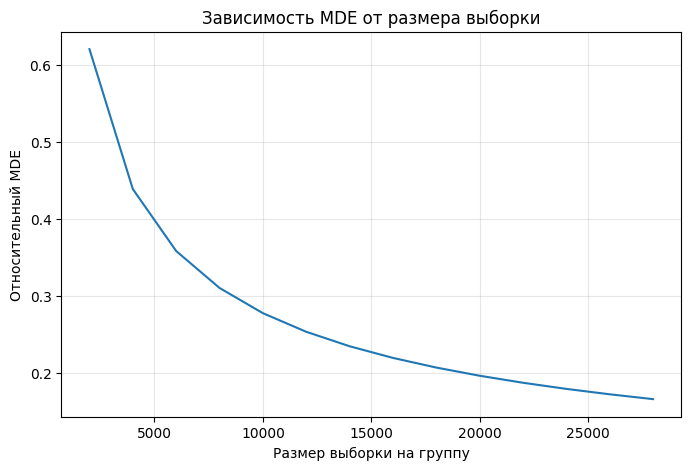

In [ ]:
import matplotlib.pyplot as plt

sample_sizes = np.arange(2_000, 30_000, 2_000)

mde_values = [
    relative_mde(baseline_std, n) / baseline_cr
    for n in sample_sizes
]

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, mde_values)
plt.xlabel("Размер выборки на группу")
plt.ylabel("Относительный MDE")
plt.title("Зависимость MDE от размера выборки")
plt.grid(alpha=0.3)
plt.show()

## Использование прокси-метрик

В условиях отсутствия достаточного числа покупок,
на раннем этапе эксперимента может быть использована прокси-метрика CTR.

CTR:
- имеет ненулевую дисперсию,
- напрямую отражает влияние персонализации,
- позволяет валидировать гипотезу до анализа secondary-метрик.

Рекомендуется рассматривать эксперимент как многошаговый:
сначала оценка эффекта на CTR, затем — на CR_enroll и выручку.

## Рекомендация: A/A-тест

Перед запуском A/B-теста рекомендуется провести A/A-тест для проверки:
- корректности рандомизации,
- стабильности логирования,
- отсутствия систематических различий между группами.

Отсутствие значимых различий в A/A-тесте является обязательным условием
для интерпретации результатов A/B-теста.

## Итоговый вывод по дизайну эксперимента

В рамках данного этапа проекта был спроектирован A/B-тест для оценки влияния персонализированной карусели курсов «Вам понравится» на поведение пользователей образовательной платформы. Экспериментальный дизайн основан на результатах exploratory analysis и учитывает особенности структуры данных и пользовательских путей.

В качестве ключевой метрики выбрана конверсия в запись на курс после клика по карточке курса (CR_enroll), так как она напрямую отражает эффективность персонализации на этапе принятия решения. Вспомогательные и охраняющие метрики используются для дополнительной интерпретации результатов и контроля качества пользовательского опыта.

Анализ исторических логов показал, что данные характеризуются высокой разреженностью и отсутствием наблюдаемых оплат среди пользователей карусели. В связи с этим оценка чувствительности эксперимента выполнена с использованием иллюстративного baseline-значения и служит для качественной оценки реализуемости эксперимента, а не для прогнозирования эффекта.

Результаты оценки минимального детектируемого эффекта указывают на то, что при текущих ограничениях по трафику и длительности теста эксперимент способен обнаружить только достаточно крупные изменения ключевой метрики. Для выявления более слабых эффектов потребуется увеличение объёма выборки, продление эксперимента или использование более чувствительных поведенческих метрик на ранних этапах анализа.

Таким образом, текущий дизайн эксперимента формирует корректную основу для запуска A/B-теста и позволяет заранее оценить требования к качеству данных, объёму трафика и интерпретации результатов при внедрении персонализированной карусели.


Дальнейшие шаги предполагают запуск A/A-теста и последующий A/B-тест с учётом выявленных ограничений.
